# Random Forest for Regression - ABC Grocery Task

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance



In [2]:
data_for_model = pickle.load(open("data/abc_abc_regression_modelling.p", "rb"))

In [3]:
data_for_model.drop("customer_id", axis = 1, inplace = True)

In [4]:
# shuffle data
data_for_model = shuffle(data_for_model, random_state = 42)

In [5]:
# deal with missing values
data_for_model.isna().sum()

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64

In [6]:
data_for_model.dropna(how = "any", inplace = True)

In [7]:
# deal with Outliers
# outlier_investigation = data_for_model.describe()
# outlier_investigation

In [8]:
# outlier_columns = ["distance_from_store", "total_sales", "total_items"]

# for column in outlier_columns:
#     lower_quartile = data_for_model[column].quantile(0.25)
#     upper_quartile = data_for_model[column].quantile(0.75)
#     iqr = upper_quartile - lower_quartile
#     iqr_extended = iqr * 2
#     min_border = lower_quartile - iqr_extended
#     max_border = upper_quartile + iqr_extended
    
#     outliers = data_for_model[(data_for_model[column] < min_border) | (data_for_model[column] > max_border)].index
#     print(f"{len(outliers)} outliers detected in column {column}")
    
#     data_for_model.drop(outliers, inplace = True)

In [9]:
# split input variables & output variable
X = data_for_model.drop(["customer_loyalty_score"], axis = 1)
y = data_for_model["customer_loyalty_score"]

In [10]:
# split out training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
# deal with categorical variables
categorical_vars = ["gender"]
one_hot_encoder = OneHotEncoder(sparse=False, drop = 'first')

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop = True), X_train_encoded.reset_index(drop = True)], axis = 1)
X_train.drop(categorical_vars, axis = 1, inplace = True)

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop = True), X_test_encoded.reset_index(drop = True)], axis = 1)
X_test.drop(categorical_vars, axis = 1, inplace = True)


C:\Users\sophi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
X_train

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,0.04,0.67,1191.53,216,53,5,22.481698,1.0
1,2.04,0.64,1581.41,343,41,4,38.570976,0.0
2,2.24,0.63,1327.51,266,48,4,27.656458,0.0
3,1.72,0.59,2094.10,352,34,3,61.591176,1.0
4,0.24,0.53,1133.45,180,56,5,20.240179,1.0
...,...,...,...,...,...,...,...,...
310,0.37,0.61,1397.66,270,50,4,27.953200,1.0
311,2.94,0.62,2397.63,282,52,5,46.108269,0.0
312,2.31,0.53,1805.39,298,48,5,37.612292,0.0
313,2.80,0.41,1524.01,278,45,3,33.866889,0.0


In [13]:
X_test

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,2.27,0.49,1506.49,281,47,3,32.052979,0.0
1,3.02,0.63,2401.64,278,50,5,48.032800,0.0
2,2.72,0.57,1620.52,246,53,5,30.575849,0.0
3,1.51,0.67,1785.67,331,53,5,33.691887,1.0
4,1.34,0.57,1682.14,364,47,4,35.790213,1.0
...,...,...,...,...,...,...,...,...
74,1.66,0.64,1811.00,344,48,4,37.729167,1.0
75,0.18,0.78,914.98,220,52,4,17.595769,1.0
76,4.02,0.48,322.92,81,13,4,24.840000,0.0
77,0.16,0.56,929.57,225,51,4,18.226863,1.0


In [18]:
# model training
regressor = RandomForestRegressor(random_state = 42)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [19]:
# predict on the test set
y_pred = regressor.predict(X_test)

In [20]:
# calculate r-squared
r_squared = r2_score(y_test, y_pred)
r_squared

0.9598627943571644

In [21]:
# cross validation
cv = KFold(n_splits = 4, shuffle = True, random_state = 42)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = "r2")
cv_scores.mean()

0.9248589874052471

In [22]:
# calculate adjusted r-squared
num_data_point, num_input_vars = X_test.shape
print(num_data_point, num_input_vars)
adjusted_r_squared = 1 -(1-r_squared)*(num_data_point-1)/(num_data_point - num_input_vars -1)
print(adjusted_r_squared)

79 8
0.9552756851408403


In [24]:
# Feature Importance

feature_importance = pd.DataFrame(regressor.feature_importances_)
feature_names = pd.DataFrame(X.columns)
feature_importance_summary = pd.concat([feature_names,feature_importance], axis = 1)
feature_importance_summary.columns = ["input_variable", "feature_importance"]
feature_importance_summary.sort_values(by = "feature_importance", inplace = True)

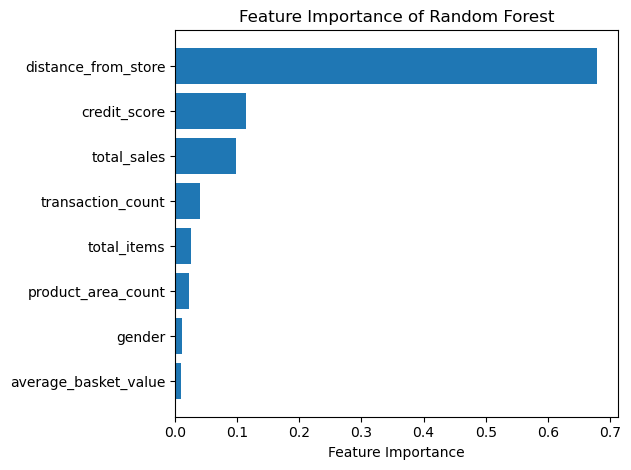

In [25]:

plt.barh(feature_importance_summary["input_variable"], feature_importance_summary["feature_importance"])
plt.title("Feature Importance of Random Forest")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

In [26]:
# Permutation Importance

result = permutation_importance(regressor, X_test, y_test, n_repeats = 10, random_state = 42)

In [27]:
result

{'importances_mean': array([1.45815078e+00, 1.27463198e-03, 1.18714590e-01, 1.29790448e-01,
        1.74368314e-02, 4.40707405e-02, 8.22511134e-03, 4.00298537e-03]),
 'importances_std': array([0.1803007 , 0.00124786, 0.02175463, 0.00978399, 0.00387002,
        0.00931063, 0.00327316, 0.00149292]),
 'importances': array([[ 1.35805446e+00,  1.33153690e+00,  1.23947045e+00,
          1.15372568e+00,  1.67458047e+00,  1.50216533e+00,
          1.70916672e+00,  1.49599713e+00,  1.44612233e+00,
          1.67068834e+00],
        [ 1.28814398e-03,  1.61237588e-03,  4.33736701e-04,
          1.63969324e-03,  5.96202645e-04,  3.81532598e-03,
         -1.27024759e-03,  1.87601088e-03,  2.02644321e-03,
          7.28634921e-04],
        [ 1.01896138e-01,  1.28003609e-01,  1.67307696e-01,
          1.20421584e-01,  1.30874769e-01,  1.03604171e-01,
          8.31711550e-02,  1.06843535e-01,  1.12764762e-01,
          1.32258481e-01],
        [ 1.17741079e-01,  1.41796746e-01,  1.29612448e-01,
     

In [28]:
permutation_importance = pd.DataFrame(result["importances_mean"])
feature_names = pd.DataFrame(X.columns)
permutation_importance_summary = pd.concat([feature_names,permutation_importance], axis = 1)
permutation_importance_summary.columns = ["input_variable", "permutation_importance"]
permutation_importance_summary.sort_values(by = "permutation_importance", inplace = True)

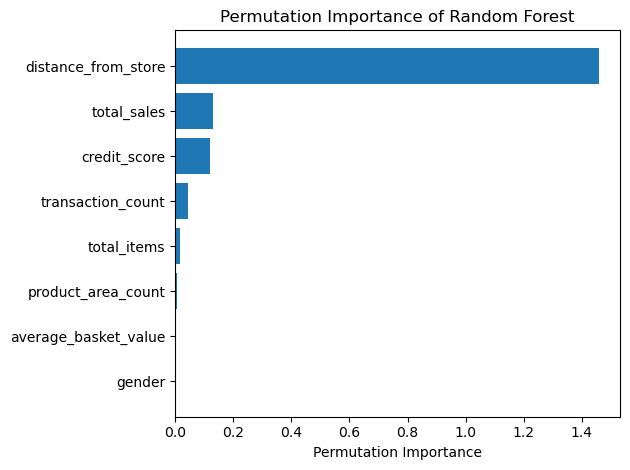

In [29]:
plt.barh(permutation_importance_summary["input_variable"], permutation_importance_summary["permutation_importance"])
plt.title("Permutation Importance of Random Forest")
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.show()

In [30]:
y_pred[0]
new_data = [X_test.iloc[0]]
regressor.estimators_

[DecisionTreeRegressor(max_features='auto', random_state=1608637542),
 DecisionTreeRegressor(max_features='auto', random_state=1273642419),
 DecisionTreeRegressor(max_features='auto', random_state=1935803228),
 DecisionTreeRegressor(max_features='auto', random_state=787846414),
 DecisionTreeRegressor(max_features='auto', random_state=996406378),
 DecisionTreeRegressor(max_features='auto', random_state=1201263687),
 DecisionTreeRegressor(max_features='auto', random_state=423734972),
 DecisionTreeRegressor(max_features='auto', random_state=415968276),
 DecisionTreeRegressor(max_features='auto', random_state=670094950),
 DecisionTreeRegressor(max_features='auto', random_state=1914837113),
 DecisionTreeRegressor(max_features='auto', random_state=669991378),
 DecisionTreeRegressor(max_features='auto', random_state=429389014),
 DecisionTreeRegressor(max_features='auto', random_state=249467210),
 DecisionTreeRegressor(max_features='auto', random_state=1972458954),
 DecisionTreeRegressor(max_f

In [31]:
predictions = []
tree_count = 0
for tree in regressor.estimators_:
    prediction = tree.predict(new_data)[0]
    predictions.append(prediction)
    tree_count +=1
print(predictions)

[0.201, 0.668, 0.117, 0.17, 0.203, 0.268, 0.17, 0.203, 0.23400000000000004, 0.17, 0.234, 0.12, 0.234, 0.174, 0.147, 0.352, 0.268, 0.234, 0.234, 0.234, 0.203, 0.17400000000000002, 0.17, 0.234, 0.177, 0.12, 0.314, 0.174, 0.234, 0.302, 0.352, 0.314, 0.234, 0.174, 0.116, 0.221, 0.147, 0.177, 0.203, 0.147, 0.12, 0.234, 0.234, 0.201, 0.177, 0.221, 0.203, 0.366, 0.201, 0.334, 0.366, 0.17, 0.448, 0.12, 0.234, 0.136, 0.23400000000000004, 0.17, 0.174, 0.201, 0.147, 0.201, 0.366, 0.344, 0.221, 0.17400000000000002, 0.234, 0.177, 0.17, 0.12, 0.42, 0.344, 0.12, 0.221, 0.17, 0.234, 0.17, 0.203, 0.234, 0.234, 0.314, 0.234, 0.234, 0.143, 0.17, 0.234, 0.201, 0.12, 0.174, 0.201, 0.35200000000000004, 0.234, 0.174, 0.506, 0.177, 0.352, 0.352, 0.147, 0.234, 0.201]


In [32]:
sum(predictions)/tree_count

0.22624000000000016

In [33]:
import pickle
pickle.dump(regressor, open("data/random_forest_regression_model.p", "wb"))
pickle.dump(one_hot_encoder, open("data/random_forest_regression_ohe.p", "wb"))